# imports and loading DataFrame

In [453]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import numpy as np
import datetime

DATE_FORMAT = "%Y-%m-%dT%H:%M:%S"
PRICE_TRESHOLD = 100_000
WEIGHT_TRESHOLD = 50


# fact table
sessions_df = pd.read_json("data/sessions.jsonl", lines=True)

# dimension tables
deliveries_df = pd.read_json("data/deliveries.jsonl", lines=True)
products_df = pd.read_json("data/products.jsonl", lines=True)
users_df = pd.read_json("data/users.jsonl", lines=True)

# adding a column with time difference in deliveries
adding a column with time difference between purchase_timestamp and delivery_timestamp in deliveries table

1. Cut microseconds from delivery_timestamp, so it will be the same format as purchase_timestamp, because there are no microseconds in purchase_timestamp (using "." as a separator).
2. Change columns format to datetime
3. Add time_diff column (as timedelta64 object).
4. Drop rows where time_diff is null (which means that delivery_timestamp was null).
5. Change type of time_diff from timedelta64 to seconds in float.
6. Drop rows where time_diff is below 0. THIS STEP IS MADE IN ### without time_diff below 0

In [454]:
# 1.
deliveries_df["delivery_timestamp"] = deliveries_df["delivery_timestamp"].str.split('.', expand=True)[0]

# 2.
deliveries_df["purchase_timestamp"] = pd.to_datetime(deliveries_df["purchase_timestamp"], format=DATE_FORMAT)
deliveries_df["delivery_timestamp"] = pd.to_datetime(deliveries_df["delivery_timestamp"], format=DATE_FORMAT)

# 3.
deliveries_df["time_diff"] = deliveries_df["delivery_timestamp"] - deliveries_df["purchase_timestamp"]

# 4.
deliveries_df = deliveries_df[deliveries_df["time_diff"].notna()]

# 5.
# time diff as duration in seconds
deliveries_df["time_diff"] = deliveries_df["time_diff"].apply(datetime.timedelta.total_seconds)

# 6.
# deliveries_df = deliveries_df[deliveries_df["time_diff"] >= 0]

# join deliveries with sessions

In [455]:
# drop rows where event_type is not equal "BUY_PRODUCT"
sessions_df = sessions_df[sessions_df["event_type"] == "BUY_PRODUCT"]
df = deliveries_df.merge(sessions_df, on="purchase_id", how="left")

In [456]:
# making sure, that timestamp == purchase_timestamp
num_of_rows_before = df.shape[0]
df = df[df["timestamp"] == df["purchase_timestamp"]]
num_of_rows_after = df.shape[0]

assert(num_of_rows_before == num_of_rows_after)

# now we can drop timestamp column, as it is redundant
df = df.drop(columns="timestamp")

# join with other tables

In [457]:
df = df.merge(users_df, on="user_id", how="left")
df = df.merge(products_df, on="product_id", how="left")

# missing data - MCAR, MAR, MNAR analysis

made without outliers but with prices below zero

In [458]:
missing_data_df = df.copy(deep=False)
missing_data_df["delivery_company_is_missing"] = missing_data_df["delivery_company"].isna()
missing_data_df["user_id_is_missing"] = missing_data_df["user_id"].isna()
missing_data_df["product_id_is_missing"] = missing_data_df["product_id"].isna()

In [459]:
# rejecting outliers for given PRICE_TRESHOLD
missing_data_df = missing_data_df[missing_data_df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
missing_data_df = missing_data_df[missing_data_df["weight_kg"] <= WEIGHT_TRESHOLD]

In [460]:
NUM_BINS_MISSING = 50

def compare_histograms_for_missing(input_df1, input_df2, end_of_title1="", end_of_title2=""):
    fig, ax = plt.subplots(4, 2)
    
    def plot_histograms_missing(input_df, plot_column, end_of_title=""):

        def plot_hist_missing(x, y, col_name, num_bins=None):
            if num_bins:
                ax[x, y].hist(input_df[col_name], bins=num_bins)
            else:
                ax[x, y].hist(input_df[col_name])
            ax[x, y].set_title(f"histogram of {col_name}" + end_of_title)
            ax[x, y].set_xlabel(col_name)
            ax[x, y].set_ylabel("# of observations")

        plot_hist_missing(0, plot_column, "time_diff", NUM_BINS_MISSING)
        plot_hist_missing(1, plot_column, "offered_discount", NUM_BINS_MISSING)
        plot_hist_missing(2, plot_column, "price", NUM_BINS_MISSING)
        plot_hist_missing(3, plot_column, "weight_kg", NUM_BINS_MISSING)

    plot_histograms_missing(input_df1, 0, end_of_title1)
    plot_histograms_missing(input_df2, 1, end_of_title2)

    fig.set_size_inches([24, 21])
    plt.show()

## delivery_company missing

In [461]:
no_missing_delivery_company = missing_data_df[missing_data_df["delivery_company_is_missing"] == False]
missing_delivery_company = missing_data_df[missing_data_df["delivery_company_is_missing"] == True]

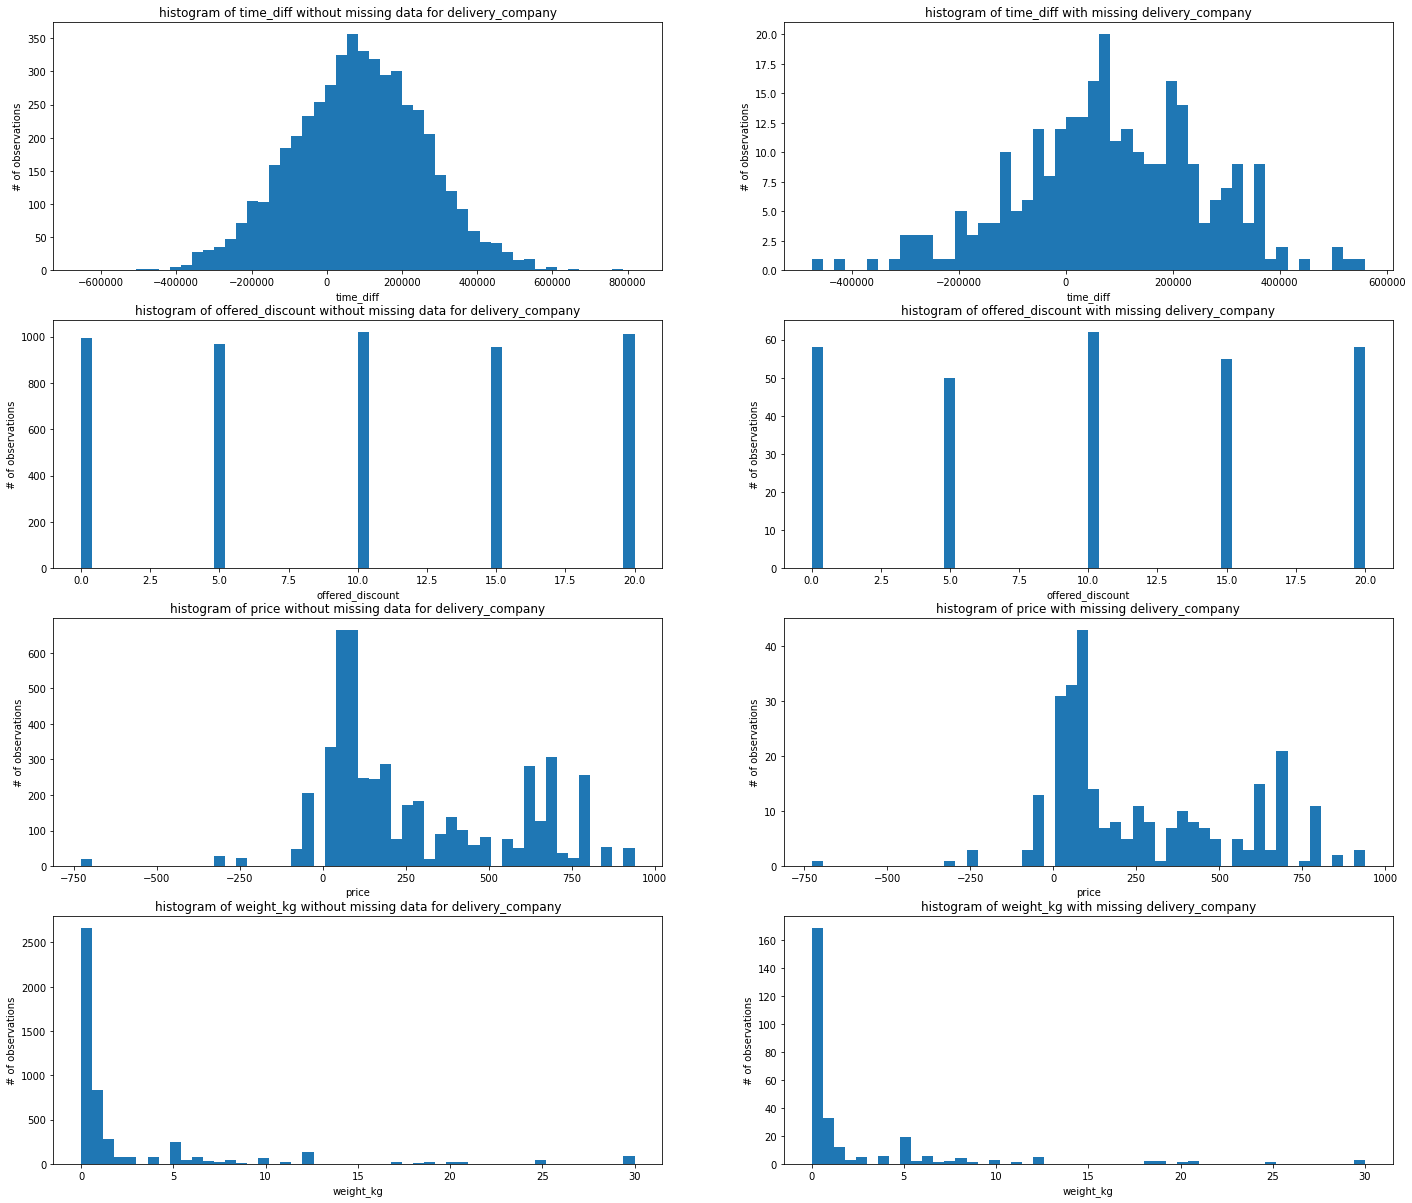

In [462]:
compare_histograms_for_missing(no_missing_delivery_company, missing_delivery_company, " without missing data for delivery_company", " with missing delivery_company")

## user_id missing

In [463]:
no_missing_user_id = missing_data_df[missing_data_df["user_id_is_missing"] == False]
missing_user_id = missing_data_df[missing_data_df["user_id_is_missing"] == True]

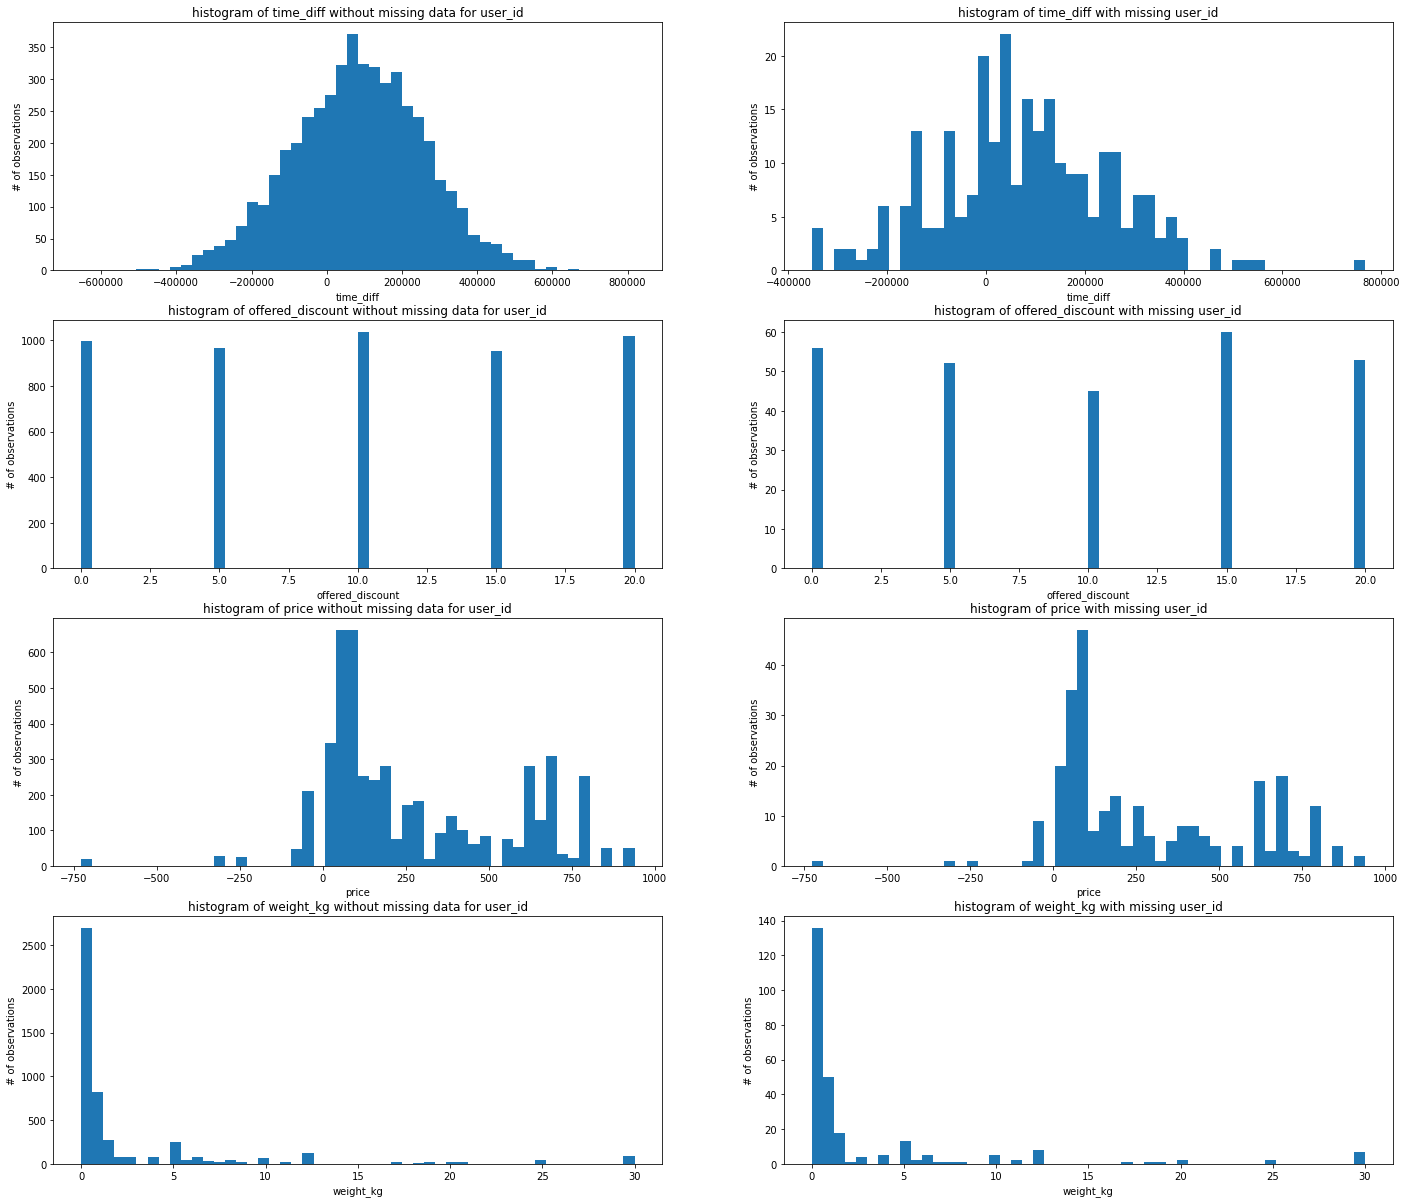

In [464]:
compare_histograms_for_missing(no_missing_user_id, missing_user_id, " without missing data for user_id", " with missing user_id")

## product_id missing

In [465]:
no_missing_product_id = missing_data_df[missing_data_df["product_id_is_missing"] == False]
missing_product_id = missing_data_df[missing_data_df["product_id_is_missing"] == True]

In [466]:
# compare_histograms_for_missing(no_missing_product_id, missing_product_id, " without missing data for product_id", " with missing product_id")

# visualizations

## time_diff histogram and log-normal distribution test

C:\Users\Milosz\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


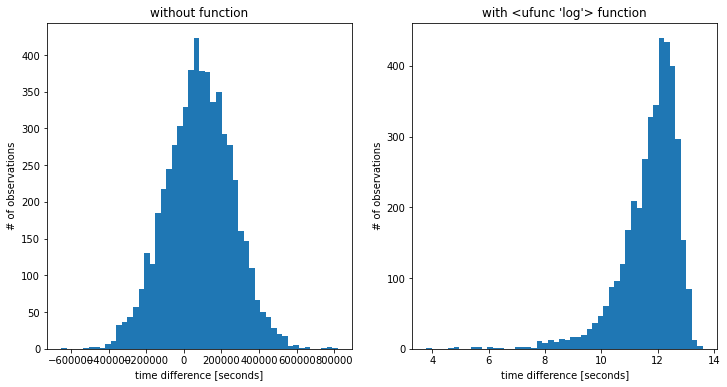

In [467]:
fig, ax = plt.subplots(1, 2)

def plot_hist(x, num_bins=50, func=None):
    if func:
        ax[x].hist(func(df["time_diff"]), bins=num_bins)
        ax[x].set_title(f"with {func} function")
    else:
        ax[x].hist(df["time_diff"], bins=num_bins)
        ax[x].set_title(f"without function")
    ax[x].set_xlabel("time difference [seconds]")
    ax[x].set_ylabel("# of observations")

plot_hist(0)
plot_hist(1, func=np.log)
# plot_hist(1, 0, func=np.log2)
# plot_hist(1, 1, func=np.log10)

fig.set_size_inches([12, 6])
plt.show()

## histograms of continuous variables

In [468]:
NUM_BINS = 50


def plot_histograms(input_df):
    fig, ax = plt.subplots(2, 2)

    def plot_hist(x, y, col_name, num_bins=None):
        if num_bins:
            ax[x, y].hist(input_df[col_name], bins=num_bins)
        else:
            ax[x, y].hist(input_df[col_name])
        ax[x, y].set_title(f"histogram of {col_name}")
        ax[x, y].set_xlabel(col_name)
        ax[x, y].set_ylabel("# of observations")

    plot_hist(0, 0, "time_diff", NUM_BINS)
    plot_hist(0, 1, "offered_discount", NUM_BINS)
    plot_hist(1, 0, "price", NUM_BINS)
    plot_hist(1, 1, "weight_kg", NUM_BINS)

    fig.set_size_inches([12, 12])
    plt.show()

### with outliers

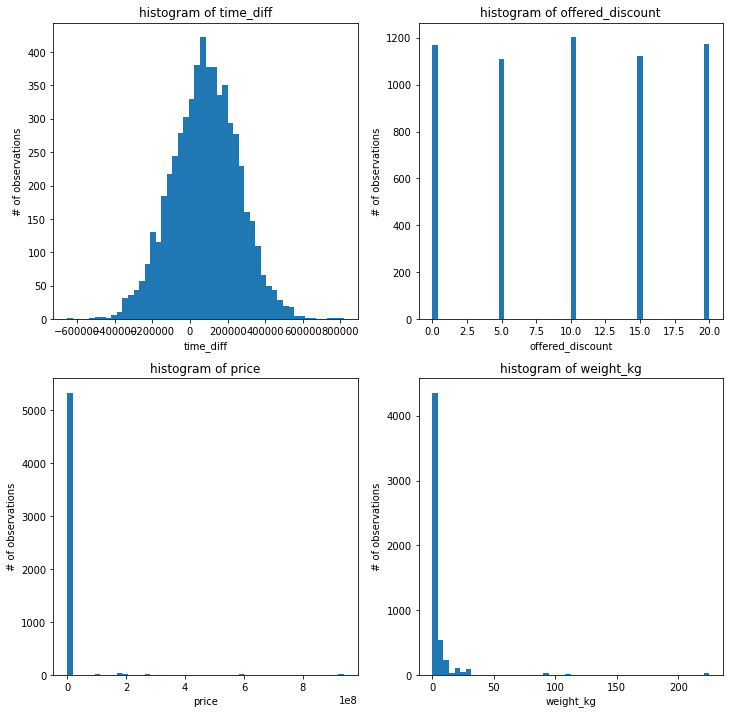

In [469]:
plot_histograms(df)

### without outliers

In [470]:
# rejecting outliers for given PRICE_TRESHOLD
df = df[df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
df = df[df["weight_kg"] <= WEIGHT_TRESHOLD]

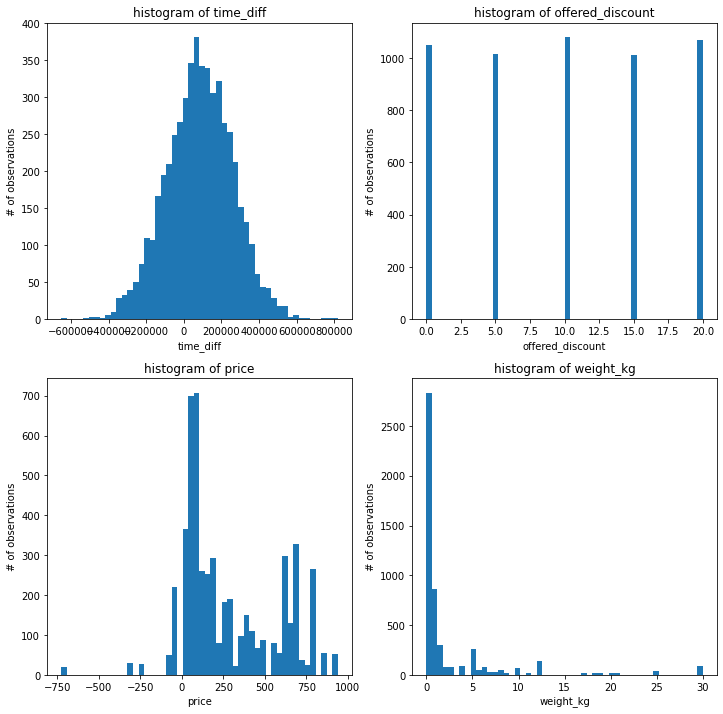

In [471]:
plot_histograms(df)

### without prices below 0

In [472]:
# deleting rows with prices below 0
df = df[df["price"] >= 0]

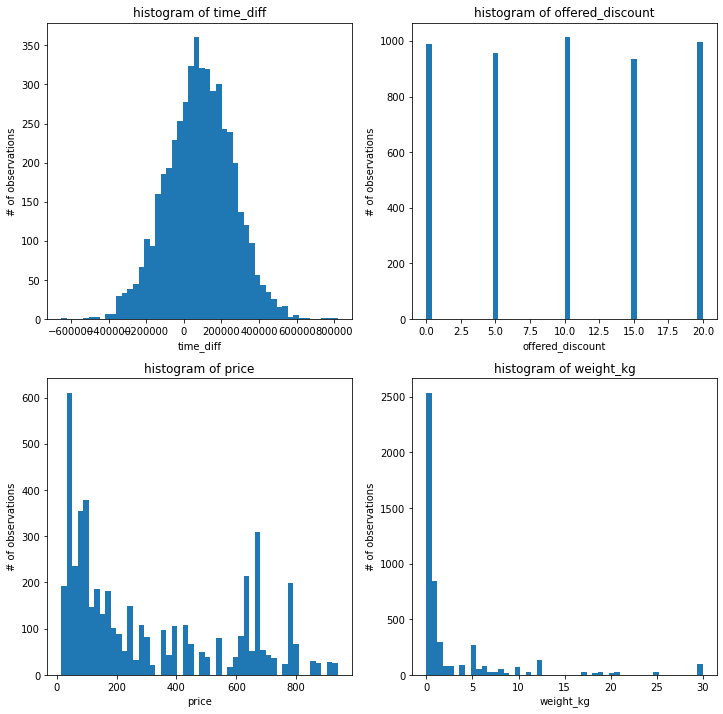

In [473]:
plot_histograms(df)

### without time_diff below 0

In [474]:
df_with_time_diff_below_0 = df
df = df[df["time_diff"] >= 0]

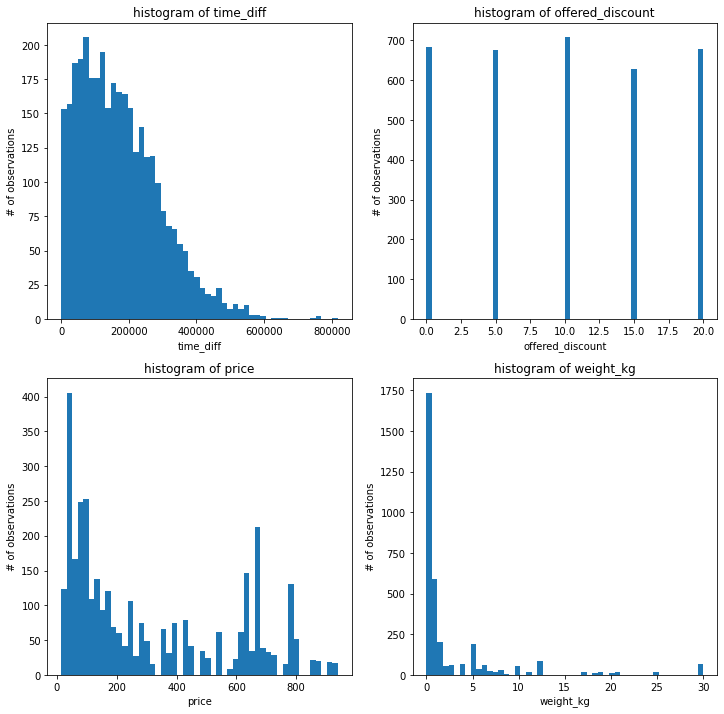

In [475]:
plot_histograms(df)

## heatmap

### with time_diff below zero

In [476]:
def update_list_of_columns():
    banned_list_of_columns = ["purchase_id", "delivery_company", "session_id", "user_id", "product_id"]
    columns_list = [col for col in df.columns.values.tolist() if col not in banned_list_of_columns]
    return columns_list

columns_list = update_list_of_columns()

(4888, 19)


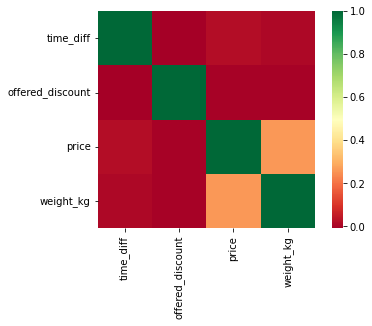

In [477]:
print(df_with_time_diff_below_0.shape)
ax = sns.heatmap(df_with_time_diff_below_0[columns_list].corr(), square=True, cmap='RdYlGn')

### without time_diff below zero

#### pearson

(3375, 19)


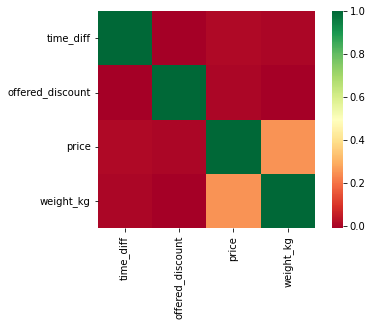

In [478]:
print(df.shape)
ax = sns.heatmap(df[columns_list].corr('pearson'), square=True, cmap='RdYlGn')

#### spearman

(3375, 19)


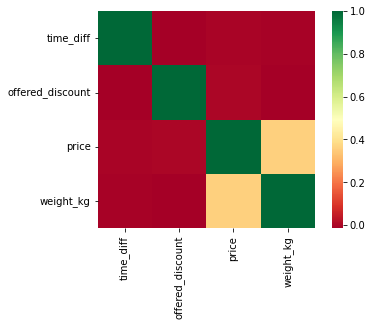

In [479]:
print(df.shape)
ax = sns.heatmap(df[columns_list].corr('spearman'), square=True, cmap='RdYlGn')

#### kendall

(3375, 19)


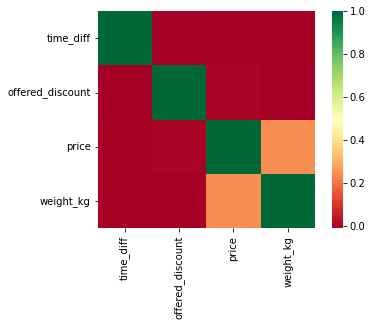

In [480]:
print(df.shape)
ax = sns.heatmap(df[columns_list].corr('kendall'), square=True, cmap='RdYlGn')

# one-hot encoding

In [481]:
# df.to_excel("data_before_one_hot_encoding.xlsx")

In [482]:
def one_hot_encode_a_col_in_pd(df, col_name):
    one_hot = pd.get_dummies(df[col_name])
    df = df.drop(columns=col_name)
    df = df.join(one_hot)
    return df

In [483]:
# test only for given attributes
attributes_names = ["city", "street"]
df = df[["time_diff", *attributes_names]]
for name in attributes_names:  
    df = one_hot_encode_a_col_in_pd(df, name)

In [484]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

SEED = 42

y = df["time_diff"].to_numpy()
X = df.drop(columns="time_diff")

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=SEED)


# reg = LinearRegression()
reg = Ridge(alpha=0.1)
# reg = Lasso(alpha=0.1)

reg.fit(X_train, y_train)
y_pred_df = pd.DataFrame()
y_pred_df["y_test"] = y_test
y_pred_df["prediction"] = reg.predict(X_test)
y_pred_df["mean of time_diff"] = np.full(675, df["time_diff"].mean())
print(y_pred_df.head())
print(y_pred_df.info())
print(y_pred_df.describe())

score = reg.score(X_test, y_test)
print(f"R^2 score = {score}")

     y_test     prediction  mean of time_diff
0  213361.0  135923.481563      174356.337185
1  292992.0  161007.681628      174356.337185
2   69756.0  170557.310479      174356.337185
3  105882.0  214296.363056      174356.337185
4   27516.0  182294.923002      174356.337185
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   y_test             675 non-null    float64
 1   prediction         675 non-null    float64
 2   mean of time_diff  675 non-null    float64
dtypes: float64(3)
memory usage: 15.9 KB
None
              y_test     prediction  mean of time_diff
count     675.000000     675.000000       6.750000e+02
mean   174414.380741  176221.628439       1.743563e+05
std    123556.467558   33796.195553       2.912541e-11
min       286.000000   39469.427838       1.743563e+05
25%     78062.500000  158656.429652       1.743563e+05
50% 

In [485]:
assert(False)

AssertionError: 

In [ ]:
# drop columns
columns_to_drop = ["delivery_timestamp", "session_id", "purchase_id", "event_type", "name", "street", "product_id"]
df = df.drop(columns=columns_to_drop)
df = df.drop(columns="optional_attributes") # na pewno do zmiany
df = df.drop(columns="purchase_timestamp") # na pewno do zmiany

In [ ]:

# one-hot encoding
df = one_hot_encode_a_col_in_pd(df, "city")
df = one_hot_encode_a_col_in_pd(df, "delivery_company")
df = one_hot_encode_a_col_in_pd(df, "product_name")
df = one_hot_encode_a_col_in_pd(df, "category_path")
df = one_hot_encode_a_col_in_pd(df, "brand")
df = one_hot_encode_a_col_in_pd(df, "user_id")

In [ ]:
print(df.shape)
columns_list = update_list_of_columns()
# ax = sns.heatmap(df[columns_list].corr(), square=True, cmap='RdYlGn')

(3375, 431)


In [ ]:
df = df.dropna()
print(df.shape)
# one-hot encoding took care of missing data, so nothing has changed

(3375, 431)


# test of linear regression model

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

SEED = 42

y = df["time_diff"].to_numpy()
X = df.drop(columns="time_diff")

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=SEED)


# reg = LinearRegression()
reg = Ridge(alpha=0.1)
# reg = Lasso(alpha=0.1)

reg.fit(X_train, y_train)
y_pred_df = pd.DataFrame()
y_pred_df["y_test"] = y_test
y_pred_df["prediction"] = reg.predict(X_test)
y_pred_df["mean of time_diff"] = np.full(675, df["time_diff"].mean())
print(y_pred_df.head())
print(y_pred_df.info())
print(y_pred_df.describe())

score = reg.score(X_test, y_test)
print(f"R^2 score = {score}")

     y_test     prediction  mean of time_diff
0  213361.0  121946.800756      174356.337185
1  292992.0  179499.003581      174356.337185
2   69756.0  145516.180887      174356.337185
3  105882.0  162486.034959      174356.337185
4   27516.0  173546.054983      174356.337185
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   y_test             675 non-null    float64
 1   prediction         675 non-null    float64
 2   mean of time_diff  675 non-null    float64
dtypes: float64(3)
memory usage: 15.9 KB
None
              y_test     prediction  mean of time_diff
count     675.000000     675.000000       6.750000e+02
mean   174414.380741  175387.179613       1.743563e+05
std    123556.467558   44347.855851       2.912541e-11
min       286.000000   25550.029287       1.743563e+05
25%     78062.500000  147488.101855       1.743563e+05
50% 